In [1]:

from torch_geometric.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import (GINConv,global_add_pool,GATConv,ChebConv,GCNConv)
from torch_geometric.datasets import ZINC
from torch_geometric.utils import to_networkx, to_dense_adj
import geoopt
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from torch_geometric.data import InMemoryDataset

#from libs.spect_conv import SpectConv,ML3Layer
#from libs.utils import Zinc12KDataset,SpectralDesign,get_n_params
#from utils_1 import get_graph_props, make_2d_graph
from torch_geometric.data import Data
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Union

import torch
from torch import Tensor

from torch_geometric.data.collate import collate

from tqdm import tqdm
import argparse


import os
#os.environ["WANDB_MODE"]="dryrun"

/home/math/maskey/anaconda3/envs/glpe/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_graphs = torch.load('data/p-embeddings/zinc_train_emb4_unp1.2.pt')


In [48]:
train_graphs2 = torch.load('data/p-embeddings/zinc_train_emb4_p1.2.pt')

In [4]:
def get_p_eigvals(X, F, p):
    n = X.shape[0]
    K = F.shape[1]
    f = F
    FFF = torch.norm(F, p,dim=0)
    FFF = torch.pow(FFF,-1)
    FFF.unsqueeze_(-1)
    FFF.unsqueeze_(-1)
    FFF.unsqueeze_(-1)
    FFF = FFF.repeat(1,n,1,1)
    FFF = torch.pow(FFF,p)

    FF = f.repeat(1,n)
    FF = FF.view(n,n,K)
    FF = FF.transpose(2,0)

    GG =FF.transpose(1,2)

    KK = FF - GG 
    KKK = KK.unsqueeze(dim=-1)
    KKK = torch.pow(torch.abs(KKK),p)

    X = X.unsqueeze(dim=1)

    KKK = KKK.type(torch.float64)
    X = X.type(torch.float64)

    LL = torch.matmul(X, KKK)
    b = torch.matmul(LL.float(),FFF.float())
    b = torch.sum(b, dim=1).squeeze_()
    return b

In [6]:
#transform = SpectralDesign(nmax=37,recfield=2,dv=2,nfreq=7) 

#dataset = Zinc12KDataset(root="graph-task/dataset/ZINC/",pre_transform=transform)
#dataset = Zinc12KDataset(root="graph-task/dataset/ZINC/",pre_transform=transform) #For Ali

########## commented this:
dataset = Zinc12KDataset(root="dataset/ZINC/")#,pre_transform=transform) #For Sohir

NameError: name 'Zinc12KDataset' is not defined

In [4]:
from libs.utils import Model_RGD,training_loop1,get_orthonromal_eigvec

In [72]:
num_eigs = 5
epochs = 1000
device = 'cpu'
p=1.2

In [7]:
from torch_geometric.utils.convert import to_networkx

In [8]:
def training_loop1(model, optimizer, sched,W, epochs=100):
    "Training loop for torch model."
    losses = []
    values = []
    best_loss_val = 1000
    lowest_grad_val = 1000
    model = model.train()
    for i in range(epochs):
        optimizer.zero_grad()
        preds = model(W)
        loss = preds
        losses.append(loss)  
        loss.backward()
        optimizer.step()
        if sched is not None:
            sched.step()
        values.append(model.weight.clone())
    return losses, values

In [9]:
class Model_RGD(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, D, p, n, K, ball):
        
        super().__init__()
        # initialize weights with eigenvectors
        self.initeigv = D.clone() #normally calculate here from the adjacency matrix, just testing now
        self.p = p
        self.n= n
        self.K = K

        self.ball = ball
        self.plane_shape = geoopt.utils.size2shape(n)
        self.num_planes = K

        # Create manifold parameters
        self.weight = geoopt.ManifoldParameter(
            self.initeigv.clone(), manifold=self.ball
        
        )
        self.reset_parameters()

    def reset_parameters(self):
        # Every manifold has a convenience sample method, but you can use your own initializer
        #Stiefel = nn.Parameter(self.initeigv.clone())#self.initeigv#.type(torch.float64).requires_grad_()
        #Stiefel = nn.Parameter(self.initeigv.clone())#self.initeigv#.type(torch.float64).requires_grad_()
        #self.weight = nn.Parameter(self.initeigv.clone())
        pass

    def forward(self, X):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        #p=2
        f = self.weight
        FF = f.repeat(1,self.n)
        FF = FF.reshape(self.n,self.n,self.K)
        #FFF = torch.sum(torch.pow(torch.abs(f), 1/p))
        FFF = torch.norm(self.weight, self.p,dim=0)
        FFF = torch.pow(FFF,self.p)
        FF = FF.transpose(2,0)
        GG =FF.transpose(1,2)
        A = X.unsqueeze(dim=1)
        #WW = A.unsqueeze(dim=-1)
        #Ww = WW.expand(-1,-1,-1,3)
        KK = FF - GG #this must be changed, since the values must be taken in norm and so on
        KKK = KK.unsqueeze(dim=-1)
        KKK = torch.pow(torch.abs(KKK),self.p)
        #print(A.size(), KKK.size())
        KKK = KKK.type(torch.float64)
        A = A.type(torch.float64)
        LL = torch.matmul(A, KKK)
        FFF = torch.pow(FFF,-1)
        FFF.unsqueeze_(-1)
        FFF.unsqueeze_(-1)
        FFF.unsqueeze_(-1)
        FFF = FFF.repeat(1,self.n,1,1)
        b = torch.matmul(LL.float(),FFF)
        b = torch.sum(b)
        return b


In [76]:
data = dataset[1]
    #Preprocessing
cora_adj = to_dense_adj(data.edge_index)
cora_adj.squeeze_()

A = cora_adj.numpy()
D, L, L_inv, eigval,eigvec = get_graph_props(A,normalize_L='none')

#We transform our eigenvectors into an orthonormalbasis such that it is in the Stiefel manifold

#Just removed for L_2 LPE


hi = get_orthonromal_eigvec(eigval,eigvec)
"""

gg = to_networkx(data)
g = dgl.from_networkx(gg)
tau=0
A = g.adjacency_matrix_scipy(return_edge_ids=False).astype(float).toarray() + tau / g.number_of_nodes()
D = np.diag((dgl.backend.asnumpy(g.in_degrees()).clip(1) + tau))
L = D-A

# Eigenvectors with PYTORCH
# Reason: pytorch has the fct torch.linalg.eigh which directly gives an ONB.
eigval, eigvec = torch.linalg.eigh(torch.tensor(L))
eigval = eigval.numpy()
eigvec = eigvec.numpy()

idx = eigval.argsort() # increasing order
eigval, eigvec = eigval[idx], np.real(eigvec[:,idx])
hi = eigvec
"""
for i in range(1,9):
    n = eigval.shape[0]
    K = num_eigs
    epochs = epochs

    # instantiate model
    p = 2- (i/10)

    W = torch.tensor(A).float().to(device)
    if i == 1:
        F_ = torch.tensor(hi[:, :K]).float().to(device) #We can use previous outputs weight
    else: F_ = m.weight.clone()
    
    m = Model_RGD(F_, p, n, K, ball = geoopt.EuclideanStiefelExact()).to(device)

    # Instantiate optimizer
    #opt = torch.optim.Adam(params=m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    #optimizer = geoopt.optim.RiemannianSGD(m.parameters(), lr=1e-3)
    optimizer = geoopt.optim.RiemannianAdam(m.parameters(), lr=1e-3)

    #optimizer = geoopt.optim.RiemannianSGD(m.parameters(), lr=1e-2, momentum=0.9)

    decayRate = 0.99
    #my_lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer)#, gamma=decayRate)
    #my_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=1, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
    #my_lr_scheduler = None
    my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    #my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.25)

    
    #Learn the 1-eigenvector. It is then given by m.weight
    start = timer()
    losses, values = training_loop1(m, optimizer,my_lr_scheduler,W, epochs)  
    end = timer()
    print(end - start, " Second")
    m.to('cpu')

1.9973438060842454  Second
1.6412811591289937  Second
1.6513288079295307  Second
1.6443249718286097  Second
1.6135440429206938  Second
1.6315234638750553  Second
1.6488915081135929  Second
1.6634756098501384  Second


data = dataset[1]
    #Preprocessing
cora_adj = to_dense_adj(data.edge_index)
cora_adj.squeeze_()

A = cora_adj.numpy()
D, L, L_inv, eigval,eigvec = get_graph_props(A,normalize_L='none')

#We transform our eigenvectors into an orthonormalbasis such that it is in the Stiefel manifold

#Just removed for L_2 LPE


hi = get_orthonromal_eigvec(eigval,eigvec)
"""

gg = to_networkx(data)
g = dgl.from_networkx(gg)
tau=0
A = g.adjacency_matrix_scipy(return_edge_ids=False).astype(float).toarray() + tau / g.number_of_nodes()
D = np.diag((dgl.backend.asnumpy(g.in_degrees()).clip(1) + tau))
L = D-A

# Eigenvectors with PYTORCH
# Reason: pytorch has the fct torch.linalg.eigh which directly gives an ONB.
eigval, eigvec = torch.linalg.eigh(torch.tensor(L))
eigval = eigval.numpy()
eigvec = eigvec.numpy()

idx = eigval.argsort() # increasing order
eigval, eigvec = eigval[idx], np.real(eigvec[:,idx])
hi = eigvec
"""

n= eigval.shape[0]
K = num_eigs
epochs = epochs

# instantiate model
W = torch.tensor(A).float().to(device)
F_ = torch.tensor(hi[:, :num_eigs]).float().to(device) #We can use previous outputs weight
m2 = Model_RGD(F_, p, n, num_eigs, ball = geoopt.EuclideanStiefelExact()).to(device) #I think we should not use F_ at initizialization, rather as a forward input so that we can start different init, or just use the reset parameters differently

# Instantiate optimizer
#opt = torch.optim.Adam(params=m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = geoopt.optim.RiemannianSGD(m.parameters(), lr=1e-2)
#optimizer = geoopt.optim.RiemannianSGD(m.parameters(), lr=1e-2, momentum=0.9)

decayRate = 0.99
#my_lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer)#, gamma=decayRate)
#my_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=1, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
my_lr_scheduler = None

#Learn the 1-eigenvector. It is then given by m.weight
start = timer()
losses = training_loop1(m2, optimizer,my_lr_scheduler,W, epochs)  
end = timer()
print(end - start, " Second")

m2.to('cpu')

In [77]:
from numba import jit

In [78]:
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def phi(x, p):
  return np.abs(x)**(p-1)*np.sign(x)

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def lp_norm(x, p):
  #gives the p-th power of the lp-norm
  y = np.sum(np.power(np.abs(x),p))
  return y

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def jacobian_grad(A, f, p):
#A is the weight matrix and f denotes the current embedding of the nodes 
#(row is the node and column are the dimension of the embedding)
#implements equation (22)
  B = np.zeros((f.shape[0], f.shape[1]))
  for i in range(0, f.shape[0]):
    for k in range(0, f.shape[1]):
      helper = [ A[i,j]*phi(f[i,k] - f[j,k],p)  for j in range(0, f.shape[0]) ]
      grad = np.sum(np.array(helper))
      grad = grad - phi(f[i,k],p)/lp_norm(f[:,k], p)
      grad = 1/lp_norm(f[:,k], p) * grad
      B[i,k] = grad
  return B

def calc_grad(A, f,p):
#implements G in Algorithm 1
  grad = jacobian_grad(A, f, p)
  G = grad - np.matmul(np.matmul(f,np.transpose(grad)),f)
  step_size = lp_norm(f, 1)/lp_norm(G,1) #for the adaptive stepsize
  return G, step_size

In [79]:
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def derivative(A, f, p):
#A is the weight matrix and f denotes the current embedding of the nodes 
#(row is the node and column are the dimension of the embedding)
#implements equation (22)
  sum_rows = 0
  for i in range(0,A.shape[0]):
    sum_cols = 0
    for j in range(0,A.shape[1]):
      sum_cols = sum_cols + A[i,j]*(np.abs(f[i] - f[j])**p)/(2*lp_norm(f,p)+eps)
    sum_rows = sum_rows + sum_cols
  B = np.zeros(f.shape[0])
  for m in range(f.shape[0]):
    helper = [A[m,j]*phi(f[m] - f[j], p) for j in range(A.shape[0])]
    grad = np.sum(np.array(helper))
    B[m] = p/(lp_norm(f,p)+eps)*(grad- (phi(f[m],p)*sum_rows))
  return B

In [80]:
@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def derivative_all(A, F, p):
#A is the weight matrix and f denotes the current embedding of the nodes 
#(row is the node and column are the dimension of the embedding)
#implements equation (22)
    norm = 0
    for i in range(F.shape[1]):
        norm = norm + np.linalg.norm(derivative(A, F[:,i], p))
    return norm

In [10]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx
import matplotlib as mpl
import matplotlib.cm as cm


def draw_molecule(g, colors, edge_mask=None, draw_edge_labels=False):

    norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
    cmap = cm.Spectral
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    #ax = plt.gca()
    #ax.set_title('Random graph')
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
        
    layout = nx.fruchterman_reingold_layout(g)
    vmin = -0.3 #colors.min()
    vmax = 0.3#colors.max()
    cmap = plt.cm.Spectral
  
    colors = m.to_rgba(colors)
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color=colors, cmap=cmap)
    """
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    """
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    
    #ax = plt.gca()
    #ax.set_title(title)
    
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x']]#.index(1.0)]
        del data['x']
    return g

In [83]:
eps = 10e-8
hello = []
for i in range(epochs):
  #print(values[i][:,1].cpu().detach().numpy())
    #hello.append( (derivative_all(A, values[i].cpu().detach().numpy(), p)))
    hello.append( np.linalg.norm(derivative(A, values[i].cpu().detach().numpy()[:,1], p)))

import matplotlib.pyplot as plt
#loss = [x.to('cpu').detach().numpy() for x in losses]
x = np.arange(1,epochs+1)
y = np.array(hello)
arg_g = y.argmin()

NameError: name 'epochs' is not defined

In [84]:
# Plotting the Graph
plt.plot(x, y)
plt.title(f"$p = {p}$ Derivate per Epoch")
plt.xlabel("epochs")
plt.ylabel("derivative value")
plt.show()

NameError: name 'x' is not defined

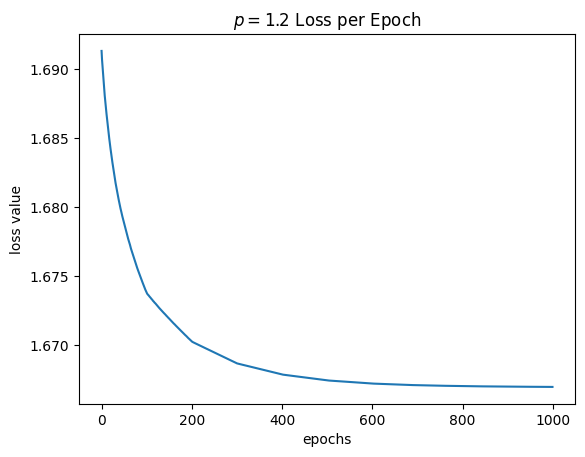

In [84]:
import matplotlib.pyplot as plt
loss = [x.to('cpu').detach().numpy() for x in losses]
x = np.arange(0,epochs)
y = np.array(loss)
arg_l = y.argmin()

# Plotting the Graph
plt.plot(x, y)
plt.title(f"$p = {p}$ Loss per Epoch")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()

In [13]:
import dgl
import torch_geometric

In [14]:
graph = dgl.to_networkx(train_graphs[0])
data = torch_geometric.utils.from_networkx(graph)
train_graphs[0].ndata["feat"]
p_eigs = train_graphs[0].ndata["eigvec"]

In [15]:
data = torch_geometric.utils.from_networkx(graph)

In [41]:
train_graphs[0].ndata["feat"]

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 5, 1, 1, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 0])

In [11]:
p_eigs = train_graphs[0].ndata["eigvec"]

In [85]:
p_eigs = values[arg_l][:,0:37]
#Order the p-eigenvector ascending with repect to the eigenvalues
p_eigvals = get_p_eigvals(W.to('cpu'), p_eigs, p)
eigidx = torch.argsort(p_eigvals)
p_eigvals = p_eigvals[eigidx]
p_eigs_l = p_eigs[:, eigidx]

In [86]:
p_eigs = values[arg_g][:,0:37]

#Order the p-eigenvector ascending with repect to the eigenvalues
p_eigvals = get_p_eigvals(W.to('cpu'), p_eigs, p)
eigidx = torch.argsort(p_eigvals)
p_eigvals = p_eigvals[eigidx]
p_eigs_g = p_eigs[:, eigidx]

In [87]:
p_eigs = values[-1][:,0:37]

#Order the p-eigenvector ascending with repect to the eigenvalues
p_eigvals = get_p_eigvals(W.to('cpu'), p_eigs, p)
eigidx = torch.argsort(p_eigvals)
p_eigvals = p_eigvals[eigidx]
p_eigs_f = p_eigs[:, eigidx]

In [77]:
i=555

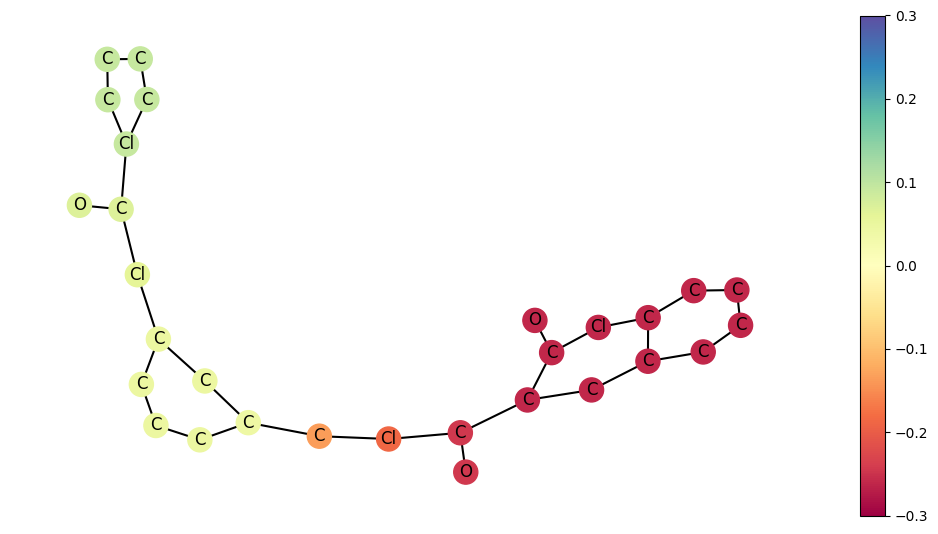

In [78]:
graph = dgl.to_networkx(train_graphs[i])
data = torch_geometric.utils.from_networkx(graph)
data.x = train_graphs[i].ndata["feat"]
p_eigs = train_graphs[i].ndata["eigvec"]

mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, p_eigs.detach().numpy()[:,0])

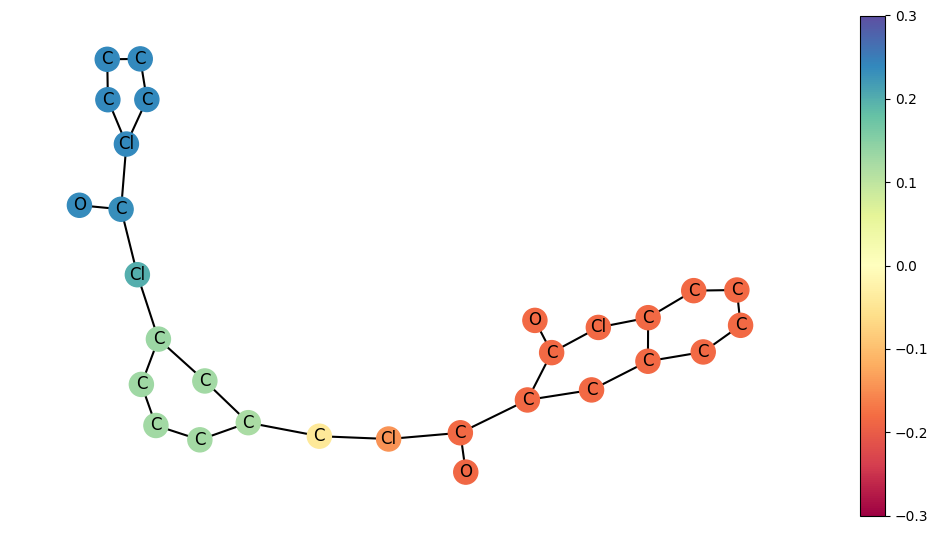

In [79]:
graph = dgl.to_networkx(train_graphs2[i])
data = torch_geometric.utils.from_networkx(graph)
data.x = train_graphs2[i].ndata["feat"]
p_eigs = train_graphs2[i].ndata["eigvec"]

mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, p_eigs.detach().numpy()[:,0])

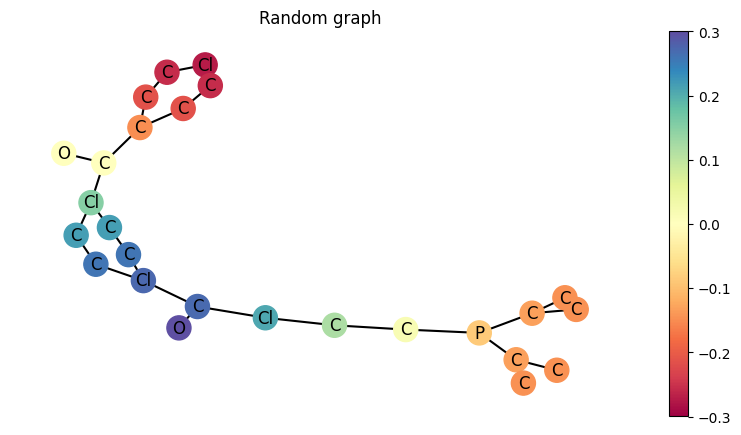

In [91]:
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, eigvec[:,2])